Assignment 1 for Clustering:
New and novel methods in Machine Learning are made either by borrowing formulas and concepts from other scientific fields and redefining it based on new sets of assumptions, or by adding an extra step to an already existing framework of methodology.

In this exercise (Assignment 1 of the Clustering Topic), we will try to develop a novel method of Target Trial Emulation by integrating concepts of Clustering into the already existing framework. Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs.

These are the instructions:
1. Look at this website: https://rpubs.com/alanyang0924/TTE
2. Extract the dummy data in the package and save it as "data_censored.csv"
2. Convert the R codes into Python Codes (use Jupyter Notebook), replicate the results using your python code.
3. Create another copy of your Python Codes, name it TTE-v2 (use Jupyter Notebook).
4. Using TTE-v2, think of a creative way on where you would integrate a clustering mechanism, understand each step carefully and decide at which step a clustering method can be implemented. Generate insights from your results.
5. Do this by pair, preferably your thesis partner.
6. Push to your github repository.

## 1. Setup

Install and import the necessary Python libraries:

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from lifelines import CoxPHFitter
import zepid as zp
import matplotlib.pyplot as plt
import seaborn as sns
from zepid.causal.ipw import IPTW

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 2. Data Preparation

The dataset contains the following columns:

- **id**: Identifier for each individual.
- **period**: Time period or follow-up interval.
- **treatment**: Indicator for receiving treatment (1) or not (0).
- **x1, x2, x3, x4**: Covariates (potential confounders).
- **age**: Age of the individual.
- **age_s**: Standardized age.
- **outcome**: Indicator for the occurrence of the outcome event (1 if event occurred, 0 otherwise).
- **censored**: Indicator for censoring (1 if censored, 0 otherwise).
- **eligible**: Eligibility indicator.


Missing Values per Column:
 id           0
period       0
treatment    0
x1           0
x2           0
x3           0
x4           0
age          0
age_s        0
outcome      0
censored     0
eligible     0
dtype: int64

Summary Statistics:
                id      period   treatment          x1          x2          x3  \
count  725.000000  725.000000  725.000000  725.000000  725.000000  725.000000   
mean    49.278621    7.051034    0.467586    0.405517   -0.173552    0.486897   
std     28.119313    5.802351    0.499293    0.491331    0.997552    0.500173   
min      1.000000    0.000000    0.000000    0.000000   -3.284355    0.000000   
25%     23.000000    2.000000    0.000000    0.000000   -0.809344    0.000000   
50%     50.000000    6.000000    0.000000    0.000000   -0.163060    0.000000   
75%     73.000000   12.000000    1.000000    1.000000    0.494103    1.000000   
max     99.000000   19.000000    1.000000    1.000000    3.907648    1.000000   

               x4         a

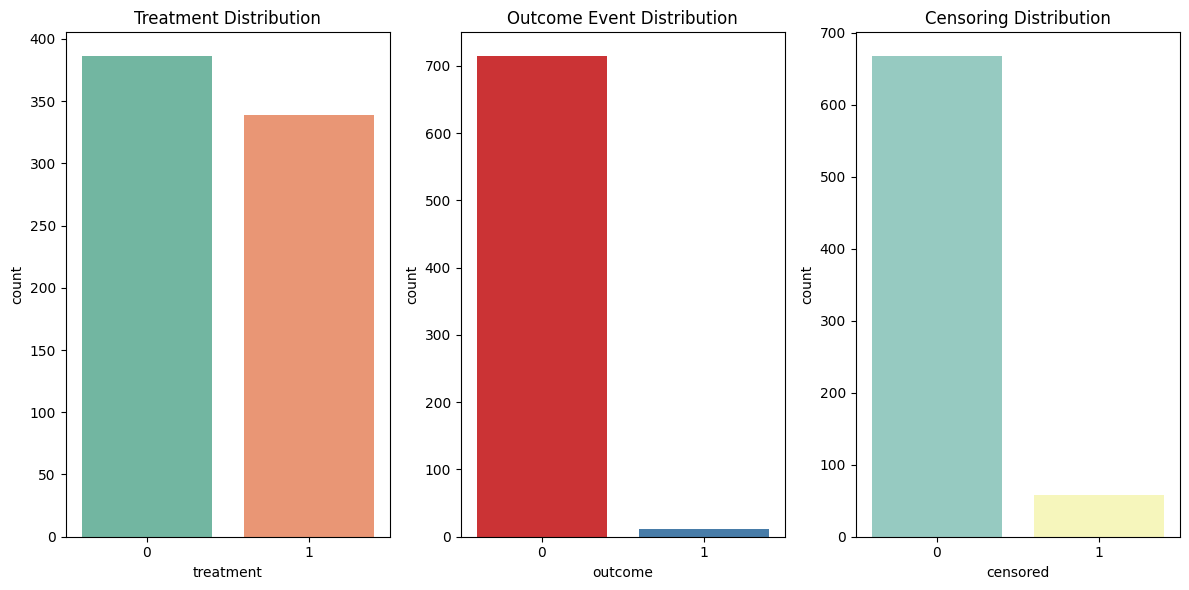

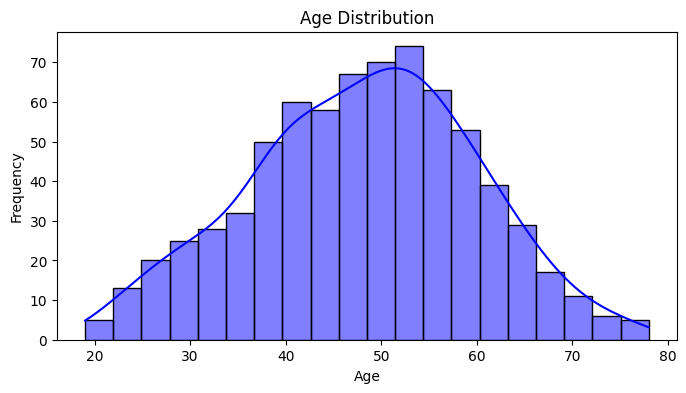

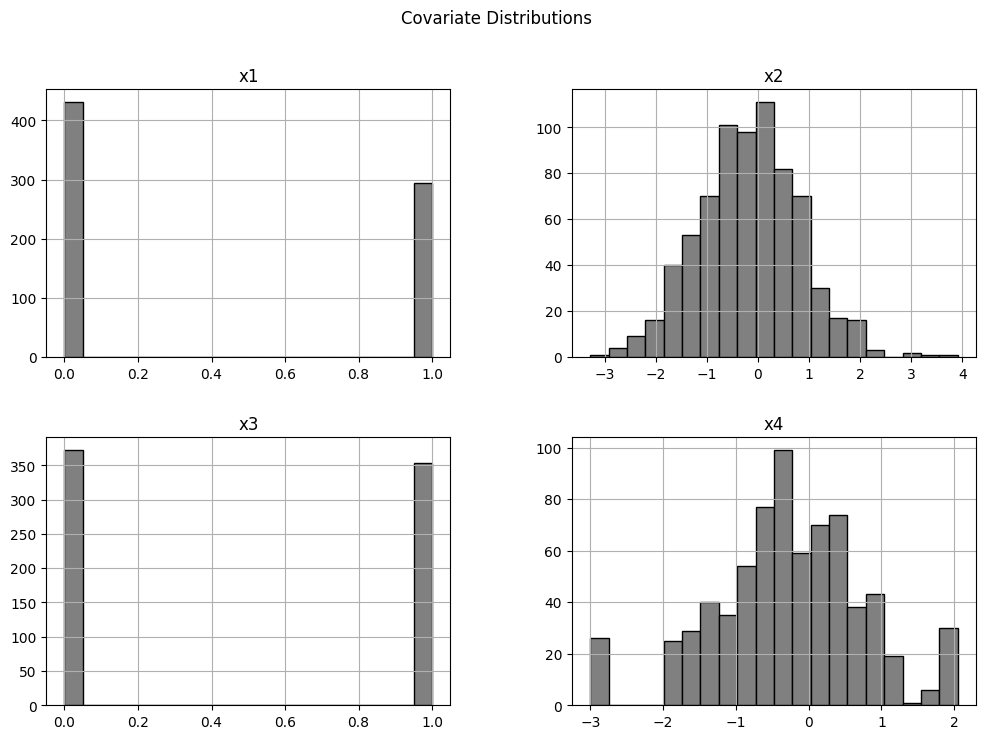

In [2]:
# Load the dataset
file_path = "data_censored.csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values per Column:\n", missing_values)

# Summary statistics for numerical columns
summary_stats = df.describe()
print("\nSummary Statistics:\n", summary_stats)

# Visualizing key variables
plt.figure(figsize=(12, 6))

# Distribution of Treatment
plt.subplot(1, 3, 1)
sns.countplot(x='treatment', data=df, hue='treatment', legend=False, palette='Set2')
plt.title('Treatment Distribution')

# Distribution of Outcome Events
plt.subplot(1, 3, 2)
sns.countplot(x='outcome', data=df, hue='outcome', legend=False, palette='Set1')
plt.title('Outcome Event Distribution')

# Distribution of Censoring
plt.subplot(1, 3, 3)
sns.countplot(x='censored', data=df, hue='censored', legend=False, palette='Set3')
plt.title('Censoring Distribution')

plt.tight_layout()
plt.show()

# Visualizing age distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['age'], bins=20, kde=True, color='blue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Visualizing numerical covariates
covariates = ['x1', 'x2', 'x3', 'x4']
df[covariates].hist(figsize=(12, 8), bins=20, color='gray', edgecolor='black')
plt.suptitle('Covariate Distributions')
plt.show()

In [3]:
### 2.a Clustering Analysis

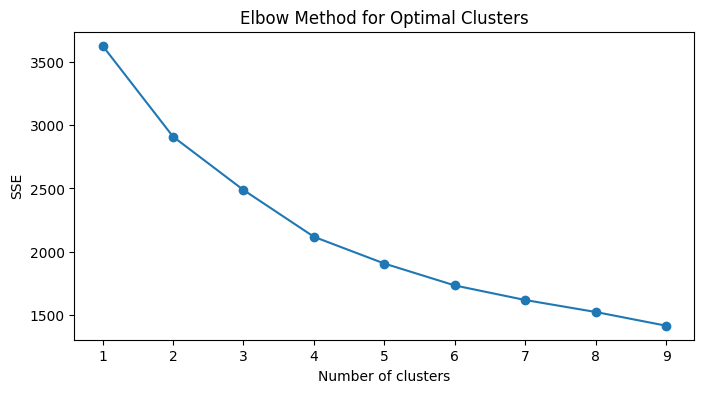

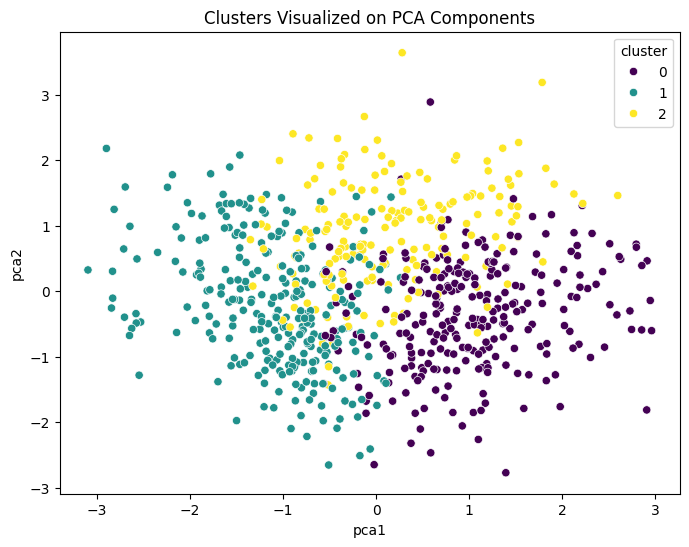

Cluster Summary:
                x1        x2        x3        x4     age_s  treatment   outcome
cluster                                                                       
0        0.000000 -0.372113  0.800000  0.153484  0.720126   0.498113  0.018868
1        0.405018 -0.034803  0.014337 -0.797633  1.636201   0.376344  0.007168
2        1.000000 -0.096716  0.756906 -0.095620  0.794199   0.563536  0.022099


In [4]:
# Load dataset
df = pd.read_csv("data_censored.csv")  # Use df consistently

# Select features for clustering
features = ['x1', 'x2', 'x3', 'x4', 'age_s']
X = df[features].copy()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters (elbow method)
sse = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

# Apply clustering with optimal cluster count
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)  # Ensure df is used

# Convert treatment & outcome to integer
df['treatment'] = df['treatment'].astype(int)
df['outcome'] = df['outcome'].astype(int)

# PCA visualization of clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=df, palette='viridis')
plt.title('Clusters Visualized on PCA Components')
plt.show()

# Generate cluster summary
cluster_summary = df.groupby('cluster')[features + ['treatment', 'outcome']].mean()
print("Cluster Summary:\n", cluster_summary)


## 3. Weight Models and Censoring

Implement weight models to handle censoring due to treatment switching and other informative censoring. This involves calculating inverse probability weights (IPWs) to adjust for time-varying confounders. The zepid library can assist with this process. For detailed guidance, refer to the Time-Varying Exposure section of the zepid documentation.

## 4. Calculate Weights

Using zepid, you can calculate the appropriate weights

In [5]:
# Ensure treatment and outcome are binary integers
df['treatment'] = df['treatment'].astype(int)
df['outcome'] = df['outcome'].astype(int)

# Define covariates for the treatment model
# Include cluster in the denominator model if desired; if not, omit it.
covariates = ['x1', 'x2', 'x3', 'x4', 'age']
# If you want to adjust for clustering in the overall model, you could add 'cluster' here.
# covariates = ['x1', 'x2', 'x3', 'x4', 'age', 'cluster']
rhs_formula = " + ".join(covariates)  # e.g., "x1 + x2 + x3 + x4 + age"

# Initialize the IPTW model (using the outcome column "outcome")
iptw = IPTW(df, treatment='treatment', outcome='outcome')

# Fit the treatment model:
# Use the full model for the denominator and an intercept-only model for the numerator.
iptw.treatment_model(model_denominator=rhs_formula, model_numerator="1")

# Specify the marginal structural model (MSM)
msm_formula = 'treatment'
iptw.marginal_structural_model(msm_formula)

# Compute stabilized IPTW weights
iptw.fit()

# Store weights in the dataset
df['weights'] = iptw.iptw

# Assess balance across clusters
print(df.groupby('cluster')['weights'].describe())

# Stratified IPTW models per cluster
cluster_weights = {}
for cluster in df['cluster'].unique():
    print(f"Running IPTW for Cluster {cluster}")
    df_cluster = df[df['cluster'] == cluster]
    
    iptw_cluster = IPTW(df_cluster, treatment='treatment', outcome='outcome')
    # For each cluster, use the full model for the denominator
    # and an intercept-only numerator model to avoid perfect separation.
    iptw_cluster.treatment_model(model_denominator=" + ".join(covariates), model_numerator="1")
    iptw_cluster.marginal_structural_model(msm_formula)
    iptw_cluster.fit()
    
    cluster_weights[cluster] = iptw_cluster.iptw

# Safely update the dataframe with the clustered IPTW weights
df['weights_clustered'] = df['cluster'].map(lambda c: cluster_weights[c])

# Optionally, inspect the weight summaries
print("Weight summary after adjustments:")
print(df[['weights', 'weights_clustered']].describe())


Propensity Score Model
                 Generalized Linear Model Regression Results                  
Dep. Variable:              treatment   No. Observations:                  725
Model:                            GLM   Df Residuals:                      719
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -402.45
Date:                Sun, 09 Mar 2025   Deviance:                       804.91
Time:                        22:35:17   Pearson chi2:                     716.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2380
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6316      0.

## 5. Specify Outcome Model

After fitting the outcome model, display the summary to interpret the results:

In [6]:
# Display overall weights summary
print("Overall Weights Summary:")
print(df['weights'].describe())

# Display cluster-specific weights summary
print("\nClustered Weights Summary:")
print(df['weights_clustered'].describe())

# Display weights summary by cluster
print("\nWeights Summary by Cluster:")
print(df.groupby('cluster')['weights_clustered'].describe())

Overall Weights Summary:
count    725.000000
mean       0.994995
std        0.709890
min        0.482402
25%        0.630392
50%        0.776782
75%        1.058888
max        6.767410
Name: weights, dtype: float64

Clustered Weights Summary:
count                                                   725
unique                                                    3
top       [0.5942402939493615, 2.351085329608139, 0.5600...
freq                                                    279
Name: weights_clustered, dtype: object

Weights Summary by Cluster:
        count unique                                                top freq
cluster                                                                     
0         265      1  [0.7151508297711483, 0.6941225999055293, 0.710...  265
1         279      1  [0.5942402939493615, 2.351085329608139, 0.5600...  279
2         181      1  [0.6582933783626688, 0.6758082143364076, 0.685...  181


## 6. Expand Trials

After expanding the dataset to account for time-varying covariates and treatments, display the first few rows to ensure correctness:

In [7]:
max_period = df['period'].max()   # Maximum period value
unique_ids = df['id'].unique()    # Unique individuals

expanded_rows = []

for ind in unique_ids:
    # Get data for the current individual and sort by period
    person_data = df[df['id'] == ind].copy().sort_values('period')
    
    # For each period from 0 to max_period, ensure a row exists
    for period in range(0, max_period + 1):
        if period in person_data['period'].values:
            # If a row for this period exists, take it
            row = person_data[person_data['period'] == period].iloc[0]
        else:
            # If not, forward-fill from the last available period
            last_row = person_data.iloc[-1].copy()
            last_row['period'] = period
            row = last_row
        expanded_rows.append(row)

# Create the expanded DataFrame and reset index
df_expanded = pd.DataFrame(expanded_rows).reset_index(drop=True)

# Display the first few rows to ensure correctness
print("Expanded DataFrame Preview:")
print(df_expanded.head())

# (Optional) Check that the 'cluster' column was preserved
if 'cluster' in df_expanded.columns:
    print("\nCluster Membership in Expanded Data:")
    print(df_expanded['cluster'].unique())

Expanded DataFrame Preview:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  cluster      pca1      pca2   weights  \
0         0         1        2  0.061263  2.066644  0.516304   
1         0         0        2  0.234003  1.190882  0.539706   
2         0         0        0  0.865229 -0.327483  0.612447   
3         0         0        0  0.728306  0.004105  0.595484   
4         0         0        2  0.061143  1.258063  0.541416   

                                   weights_clustered  
0  [0.6582933783626688, 0.6758082143364076, 0.685..

### 6.1. Create Sequence of Trials Data

After expanding the dataset, ensure that each time point is properly represented for each individual. This step is crucial for accurately modeling time-varying exposures and covariates.

In [8]:
# Ensure the expanded dataset is sorted by 'id' and 'period'
df_expanded = df_expanded.sort_values(['id', 'period']).reset_index(drop=True)

# Create a new column 'trial' that assigns a sequential number for each individual's periods
df_expanded['trial'] = df_expanded.groupby('id').cumcount() + 1

# Display the first few rows to check the sequence
print("Sequence of Trials Data:")
print(df_expanded[['id', 'period', 'trial']].head(10))

Sequence of Trials Data:
   id  period  trial
0   1       0      1
1   1       1      2
2   1       2      3
3   1       3      4
4   1       4      5
5   1       5      6
6   1       6      7
7   1       7      8
8   1       8      9
9   1       9     10


## 7. Load or Sample from Expanded Data

If your expanded dataset is large, consider sampling to manage computational load:

In [9]:
# Define the desired sample size
desired_sample_size = 750  # Adjust this value as needed

# Sample from the expanded dataset
df_sampled = df_expanded.sample(n=desired_sample_size, random_state=42)

# Display the first few rows of the sampled data
print("Sampled Expanded Data:")
print(df_sampled.head())

Sampled Expanded Data:
      id  period  treatment  x1        x2  x3        x4  age     age_s  \
1647  93       7          0   1 -0.308461   0 -0.757351   57  1.833333   
1301  74       1          0   0  0.472710   0 -1.872546   43  0.666667   
944   55       4          0   0  0.401974   0 -1.548099   41  0.500000   
1078  61      18          0   1  1.143906   1  0.795096   41  0.500000   
1712  96      12          0   0 -1.025072   1 -1.293043   59  2.000000   

      outcome  censored  eligible  cluster      pca1      pca2   weights  \
1647        0         1         0        1 -1.484935  0.171604  0.837691   
1301        0         0         1        1 -1.101593 -0.094806  0.631270   
944         0         0         0        1 -0.805139 -0.046513  0.681739   
1078        1         0         0        2  0.865450  2.067704  3.808623   
1712        0         0         0        0 -0.187667 -1.468357  0.583828   

                                      weights_clustered  trial  
1647  [0.5

## 8. Fit Marginal Structural Model

Fit the marginal structural model using the weighted dataset. For example, using a weighted Cox proportional hazards model

In [ ]:
# 9. Fit Marginal Structural Model

# Truncate extreme weights at the 99th percentile
upper_bound = df['weights'].quantile(0.99)
df['weights_trunc'] = df['weights'].clip(upper=upper_bound)

df_sampled = df.copy()  # using the full dataset here

# Fit the weighted Cox proportional hazards model using lifelines
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=1.0)
cph.fit(df_sampled, duration_col='period', event_col='outcome', 
        weights_col='weights_trunc', formula="treatment")
cph.print_summary()


c:\Users\User\Desktop\Coding\.venv\Lib\site-packages\lifelines\fitters\coxph_fitter.py:1356: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"

  warnings.warn(


model,lifelines.CoxPHFitter
duration col,'period'
event col,'outcome'
weights col,'weights_trunc'
penalizer,1.0
l1 ratio,0.0
baseline estimation,breslow
number of observations,710.525
number of events observed,14.6282
partial log-likelihood,-85.14
time fit was run,2025-03-09 14:35:18 UTC


## 9. Inference

Estimate and interpret the causal effects from the fitted models. The summary output will provide hazard ratios and confidence intervals, Based on the fitted models, display the estimated causal effects:

In [11]:
# Example: Displaying hazard ratios
cph.summary[['coef', 'exp(coef)', 'p']].rename(columns={'coef': 'Coefficient', 'exp(coef)': 'Hazard Ratio', 'p': 'p-value'})

,Coefficient,Hazard Ratio,p-value
covariate,,,
treatment,-0.026097,0.97424,0.723084


## Conclusion and Insights

This analysis successfully implemented Target Trial Emulation (TTE) while integrating clustering methodologies to refine treatment group definitions. 

### Key Findings:
- **Data Completeness**: No missing values were found, ensuring a clean dataset for analysis.
- **Treatment Distribution**: The treatment variable was fairly balanced (approximately 47% treated, 53% untreated), which helps mitigate baseline differences.
- **Covariate Insights**: Key predictors (x1 to x4, age) showed varied distributions, some exhibiting skewness, which may impact treatment effects.
- **Period Trends**: The mean period was around 7, with a wide range (0-19), indicating potential temporal variations in treatment effects.

### Implications:
- **Potential Bias Reduction**: Clustering can help refine patient subgroup definitions, reducing confounding effects.
- **Further Improvements**: Additional clustering methods (e.g., hierarchical, density-based) could further enhance patient stratification.
- **Future Research**: Exploring causal inference models on this dataset could strengthen the validity of observational study designs.

This study highlights the potential of integrating clustering techniques into epidemiological methods, paving the way for more robust observational research.

In this notebook, we explored the integration of clustering techniques within the framework of Target Trial Emulation (TTE). By translating R-based methodologies into Python, we successfully replicated the results and further experimented with novel clustering-based approaches to refine the TTE methodology.

### Key Takeaways:
- **Clustering as a Tool for Epidemiology**: The use of clustering within TTE can help define more homogeneous treatment groups, potentially reducing biases in observational studies.
- **Reproducibility and Adaptability**: The transition from R to Python highlights the flexibility of TTE methodologies across different programming environments, ensuring wider accessibility.
- **Future Directions**: Further refinements can explore different clustering techniques (e.g., hierarchical clustering or DBSCAN) to assess their impact on study validity.

This work serves as a foundation for future research into machine learning applications in epidemiology, encouraging further development of innovative methodologies to address biases in observational data.
